In [1]:
import os
import pandas as pd
import numpy as np
import time
import random
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pickle
from collections import namedtuple

import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
from torch.distributions import Normal
from torch.utils.tensorboard import SummaryWriter

from utils.model import PPO
from utils.replaybuffer import RolloutBuffer
from utils.AI_Interface import *
from utils.reward import *
from utils.dist import MultiCategoricalDistribution

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
state_dim = 428
action_dim = 8
lr_actor = 0.0003
lr_critic = 0.001 
gamma = 0.99
# K_epochs = 1
K_epochs = 80
eps_clip = 0.2
has_continuous_action_space = False
action_std = 0.6

fStickLat_shape=21
fStickLon_shape=21
fThrottle_shape=11
fRudder_shape=21
eMainTaskMode=2
eEleScanLine_shape=2
eAziScanRange=3
WeaponLaunch=2

action_dims = [fStickLat_shape, fStickLon_shape, fThrottle_shape, fRudder_shape,
                           eMainTaskMode, eEleScanLine_shape, eAziScanRange, WeaponLaunch]

agent = PPO(state_dim, action_dim, 
            fStickLat_shape, fStickLon_shape,
            fThrottle_shape, fRudder_shape,
            eMainTaskMode, eEleScanLine_shape,
            eAziScanRange, WeaponLaunch, 
            lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)
mcd = MultiCategoricalDistribution(action_dims)

data = pd.read_csv('../data',header=None)

i = 2
while i < (len(data)-1):
    # 假设我们是红色飞机，蓝色飞机的状态动作默认不知道
    # 把红蓝的input做成state，动作是红色的output
    # 注意：428-609是空空导弹数据，不能用作state
    # 注意！！！：离散PPO的过程中的action都得是每个空间中每个动作的logits
    # 仅在交互时通过max找到index，再对应到具体动作上
    
#     state = data.iloc[i][:428].tolist() + data.iloc[i+1][:428].tolist()
    state = data.iloc[i][:428].tolist()
    action = data.iloc[i][609:].tolist()
    action[-2] = action[-2]/120
    action[-3] = action[-3]/4
    
    
    # 为了方便做奖励，将所有变量都归类
    # 需要当前input，当前output，上一步input
    input_r_cur, output_r_cur = getStateAndAction(data.iloc[i])
    input_b_cur, output_b_cur = getStateAndAction(data.iloc[i+1])
    input_r_pre, _ = getStateAndAction(data.iloc[i-2])
    input_b_pre, _ = getStateAndAction(data.iloc[i-1])
    reward = getReward(input_r_pre, input_b_pre,
             output_r_cur, output_b_cur,
             input_r_cur, input_b_cur)
    
    # 终止flag
    # 不知道时间单位，暂时没有考虑终止条件2
    if ((input_r_cur.m_AircraftBasicInfo.m_bAlive == 0 or 
        input_r_cur.m_AircraftBasicInfo.m_fFuel <= 0 or
        input_r_cur.m_AircraftMoveInfo.m_dSelfAlt <= 0) or
        (input_b_cur.m_AircraftBasicInfo.m_bAlive == 0 or 
        input_b_cur.m_AircraftBasicInfo.m_fFuel <= 0 or
        input_b_cur.m_AircraftMoveInfo.m_dSelfAlt <= 0)):
        for i in range(len(input_r_cur.m_AAMDataSet.m_AAMData)):
            if (input_r_cur.m_AAMDataSet.m_AAMData[i].m_eAAMState != 0) or \
            (input_b_cur.m_AAMDataSet.m_AAMData[i].m_eAAMState != 0):
                done = 0
            else:
                done = 1
    else:
        done = 0
        
    state = torch.tensor(state).to(device)
    action = torch.tensor(action).to(device)
    reward = torch.tensor(np.array([reward])).to(device)
    done = torch.tensor([done]).to(device)
    
    # 这里应该需要有对应的概率
    mcd.proba_distribution(agent.policy.actor(state).unsqueeze(0))
#     action = mcd.get_actions(deterministic=False)
    logprob = mcd.log_prob(action.unsqueeze(0))
    
    agent.buffer.states.append(state)
    agent.buffer.actions.append(action)
    agent.buffer.logprobs.append(logprob)
    agent.buffer.rewards.append(reward)
    agent.buffer.is_terminals.append(done)
    i = i + 2

/home/huangchenghao/TX_airplane/PPO/utils/dist.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  self.distribution = [torch.distributions.Categorical(logits=F.softmax(split)) for split in torch.split(action_logits, tuple(self.action_dims), dim=1)]


In [4]:
agent.update()

agent.save('checkpoint/PPO.pt')

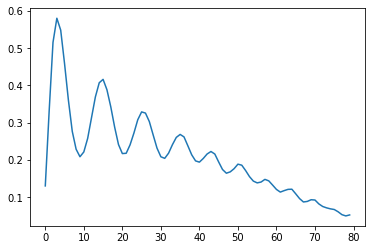

In [5]:
plt.plot(agent.loss_record)

In [7]:
torch.onnx.export(agent.policy_old.cpu(),
                  (torch.randn(428)),
                  "checkpoint/model.onnx", 
                   export_params=True,        # 是否保存训练好的参数在网络中
                   opset_version=10,          # ONNX算子版本
                   do_constant_folding=True,  # 是否不保存常数输出（优化选项）
                   input_names = ['input'],   
                   output_names = ['output'])

/home/huangchenghao/TX_airplane/PPO/utils/model.py:104: TracerWarning: Converting a tensor to a Python list might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  real_action.append(action_list[i][action.cpu().tolist()[0][i]])
